In [213]:
import sys, time
import pandas as pd
import datetime as dt
from IPython.display import display
import numpy as np

In [214]:
! pip install -U airportsdata

In [215]:
import airportsdata
airports = airportsdata.load()
# Replace non-ascii characters
for (k,v) in airports.items():
    old = airports[k]['name']
    airports[k]['name'] = ''.join([i if ord(i) < 128 else ' ' for i in old])

In [216]:
path = 'flightlist_20191201_20191231.csv'

In [217]:
#helpers
space = " "
tab = space * 2
two_tabs = space * 4
nl = "\n"
left_bracket = f"{'['}"
right_bracket = f"{']'}"

In [218]:
#Write an edge
def write_edge(source,target,value,f):
    record = (f"{tab}edge{nl}"
              f"{tab}{left_bracket}{nl}"
              f"{two_tabs}source{space}\"{source}\"{nl}"
              f"{two_tabs}target{space}\"{target}\"{nl}"
              f"{two_tabs}value{space}{value}{nl}"
              f"{tab}{right_bracket}{nl}")
    f.write(record.encode('ascii'))

In [219]:
#Write a node
def write_node(airport,f):
    record = (f"{tab}node{nl}"
              f"{tab}{left_bracket}{nl}"
              f"{two_tabs}id{space}\"{airport['icao']}\"{nl}"
              f"{two_tabs}label{space}\"{airport['name']}-{airport['country']}\"{nl}"
              f"{tab}{right_bracket}{nl}")
    f.write(record.encode('ascii'))

In [220]:
def csv_to_gml(csv_file_path, df):
    df = pd.read_csv(csv_file_path,usecols=['origin','destination'],dtype=str)
    df = df.dropna()
    df = df.groupby(['origin','destination'], as_index=False).size().rename(columns={"size":"flight_count"})
    f = open(f"{csv_file_path.split('.')[0]}.gml", "wb")
    #loop helpers
    added = []
    added_edges_sets = []
    ind = 0

    #Root node
    f.write(f"graph{nl}".encode("ascii"))
    f.write(f"{left_bracket}{nl}".encode("ascii"))

    #Generate nodes
    for i, r in df.iterrows():
        #increment, as index not reliable
        ind += 1
        origin = r['origin']
        destination = r['destination']
        #Check for duplicates
        
        # Also we want only airport with iata code, these airport are tend not to be private or military airports
        if (origin not in added and origin in airports and airports[origin]['iata'] != ''):
            #Add to list
            added.append(origin)
            write_node(airports[origin],f)
        if (destination not in added and destination in airports and airports[destination]['iata'] != ''):
            #Add to list
            added.append(destination)
            write_node(airports[destination],f)
        #print the progress
        if ind % 100000 == 0:
            print(f"Writing Nodes {ind} of {len(df)}")

    print(nl+"Printing nodes over")

    #flush index
    ind = 0    
    #Generate edges    
    for i, r in df.iterrows():
        #increment, as index not reliable
        ind += 1
        origin = r['origin']
        destination = r['destination']
        edge_set = set([origin,destination])
        if (origin in added and destination in added and edge_set not in added_edges_sets):
            #Find all the records between origin and destination
            cond = ((df['origin'] == origin) & (df['destination'] == destination))|((df['origin'] == destination) & (df['destination'] == origin))
            n_flights = df.loc[cond]['flight_count'].sum()
            write_edge(origin, destination, n_flights,f)
            added_edges_sets.append(edge_set)
        if ind % 1000 == 0:
            sys.stdout.flush()
            sys.stdout.write('\r')
            sys.stdout.flush()
            sys.stdout.write(f"Writing Edges {ind} of {len(df)}")


    print(nl+"Printing nodes and edges over")

    #closing node
    f.write(f"{right_bracket}{nl}".encode("ascii"))
    f.close()

In [221]:
csv_to_gml(path, df)

Writing Nodes 100000 of 170990

Printing nodes over
Writing Edges 170000 of 170990
Printing nodes and edges over


In [222]:
import networkx as nx
g = nx.read_gml("flightlist_20191201_20191231.gml")

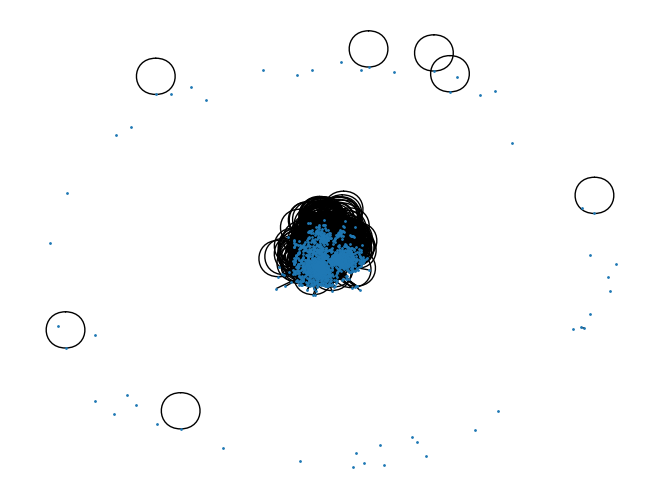

In [223]:
nx.draw(g,nx.spring_layout(g),node_size=1)